# Satellite Imagery Data Preparation

In [1]:
!pip install patchify
!pip install scikit-learn
!pip install opencv-python
!pip install Pillow
!pip install matplotlib

# pip install tensorflow==2.10


In [2]:

import os
import cv2
from PIL import Image 
import numpy as np 
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [3]:
minmaxscaler = MinMaxScaler()


In [4]:
dataset_root_folder = 'C:/Users/Fengren/Documents/ComputerVision/Semanticsegmentationdataset'

In [5]:
image_patch_size = 256


In [6]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)

     

In [7]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
     

In [8]:

print(len(image_dataset))
print(len(mask_dataset))

945
945


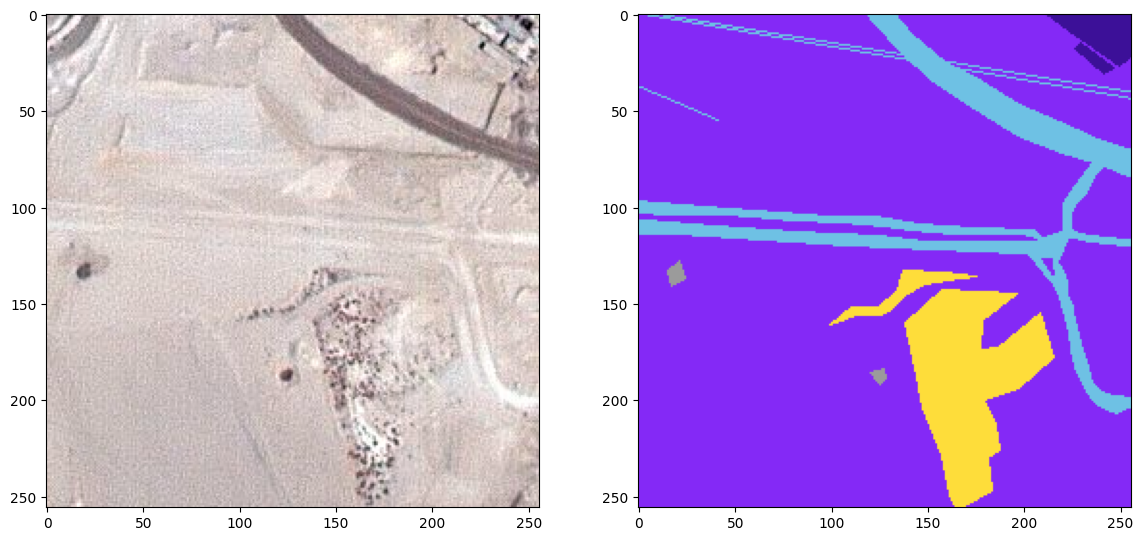

In [9]:

random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])
     

In [10]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [11]:
label = individual_patched_mask

In [12]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [13]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [14]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [15]:
np.unique(labels)


array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [16]:
print("Total unique labels based on masks: ",format(np.unique(labels)))


Total unique labels based on masks:  [0 1 2 3 4 5]


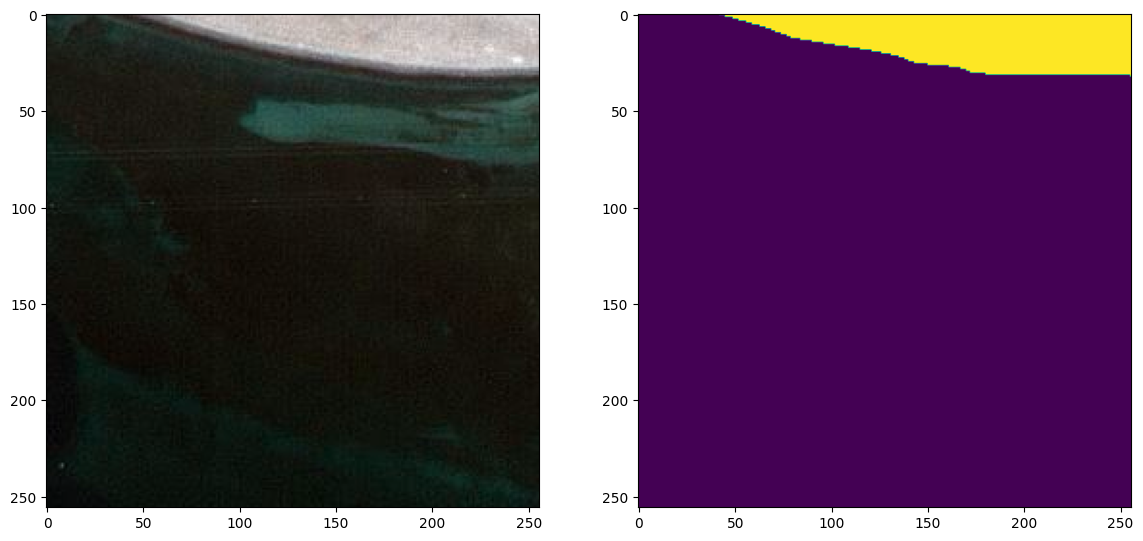

In [17]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [18]:
total_classes = len(np.unique(labels))

In [19]:
total_classes

6

In [20]:
import sys
print(sys.version)

3.9.21 (main, Dec 11 2024, 16:35:24) [MSC v.1929 64 bit (AMD64)]


In [21]:
from tensorflow.keras.utils import to_categorical 

In [22]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)


In [23]:
master_trianing_dataset = image_dataset


In [24]:
from sklearn.model_selection import train_test_split


In [25]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)


In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [27]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [28]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


# Develop Unet Model CNN on Satellite Imagery Data

In [29]:
!pip install -U segmentation-models


  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   -------- ------------------------------- 2.9/12.9 MB 14.0 MB/s eta 0:00:01
   ----------------- ---------------------- 5.8/12.9 MB 14.1 MB/s eta 0:00:01
   -------------------------- ------------- 8.7/12.9 MB 14.1 MB/s eta 0:00:01
   -------------------------------- ------- 10.5/12.9 MB 12.8 MB/s eta 0:00:01
   ------------------------------------ --- 11.8/12.9 MB 11.5 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 10.9 MB/s eta 0:00:00
Using cached imageio-2.37.0-py3-none-any.whl (315 kB)
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 8.9 MB/s eta 0:00:00


In [30]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [31]:
from keras import backend as K

In [32]:

def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [33]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [34]:
metrics = ["accuracy", jaccard_coef]


In [35]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [36]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes, 
                          image_height=image_height, 
                          image_width=image_width, 
                          image_channels=image_channels)

In [37]:
model = get_deep_learning_model()


In [38]:
model.get_config()


{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   'config': {'name': '

# Generating loss function
dice loss > Focal Loss > Total Loss
Total Loss = (Dice loss + (1*Focal Loss))

In [39]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]


In [40]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [41]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [42]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [43]:
total_loss = dice_loss + (1 * focal_loss)

# Model compilation


In [44]:
import tensorflow as tf

In [45]:
tf.keras.backend.clear_session()

In [46]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [48]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=100,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/100
51/51 [==============================] - 210s 4s/step - loss: 0.9976 - accuracy: 0.5674 - jaccard_coef: 0.2791 - val_loss: 0.9879 - val_accuracy: 0.6713 - val_jaccard_coef: 0.3249
Epoch 2/100
51/51 [==============================] - 195s 4s/step - loss: 0.9768 - accuracy: 0.6880 - jaccard_coef: 0.3876 - val_loss: 0.9662 - val_accuracy: 0.7094 - val_jaccard_coef: 0.4320
Epoch 3/100
51/51 [==============================] - 189s 4s/step - loss: 0.9638 - accuracy: 0.7132 - jaccard_coef: 0.4535 - val_loss: 0.9622 - val_accuracy: 0.7104 - val_jaccard_coef: 0.4644
Epoch 4/100
51/51 [==============================] - 189s 4s/step - loss: 0.9563 - accuracy: 0.7420 - jaccard_coef: 0.4912 - val_loss: 0.9626 - val_accuracy: 0.7128 - val_jaccard_coef: 0.4886
Epoch 5/100
51/51 [==============================] - 188s 4s/step - loss: 0.9499 - accuracy: 0.7578 - jaccard_coef: 0.5137 - val_loss: 0.9618 - val_accuracy: 0.7179 - val_jaccard_coef: 0.4834
Epoch 6/100
51/51 [=====================

In [50]:
history_a = model_history


In [51]:
history_a.history


{'loss': [0.997610867023468,
  0.9767516255378723,
  0.9638213515281677,
  0.9563356041908264,
  0.9498652815818787,
  0.9456205368041992,
  0.9401286244392395,
  0.9369783401489258,
  0.9325751662254333,
  0.9281071424484253,
  0.9258882999420166,
  0.9242731332778931,
  0.9226734042167664,
  0.921592652797699,
  0.9197013974189758,
  0.9184533357620239,
  0.9179743528366089,
  0.9171437621116638,
  0.9149604439735413,
  0.9140945076942444,
  0.9132604598999023,
  0.9129936695098877,
  0.9120243787765503,
  0.91446852684021,
  0.9122814536094666,
  0.910168468952179,
  0.9095156192779541,
  0.9101321697235107,
  0.9142765402793884,
  0.9097842574119568,
  0.909146249294281,
  0.9078071117401123,
  0.9058515429496765,
  0.9050798416137695,
  0.9042307734489441,
  0.9039266109466553,
  0.9045163989067078,
  0.9051374793052673,
  0.9035449028015137,
  0.9023812413215637,
  0.9027817249298096,
  0.9026746153831482,
  0.9019968509674072,
  0.9015787839889526,
  0.9036508798599243,
  0.9038

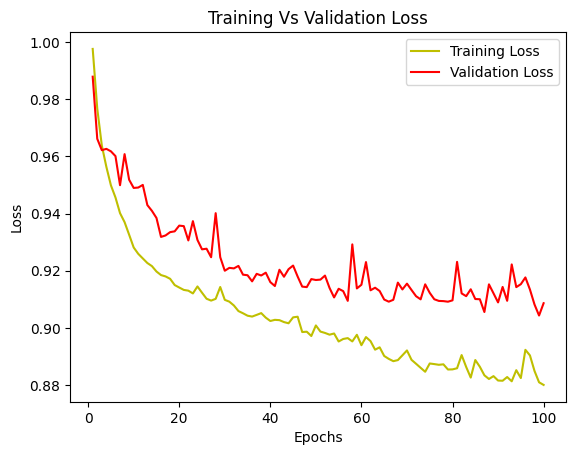

In [52]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
     

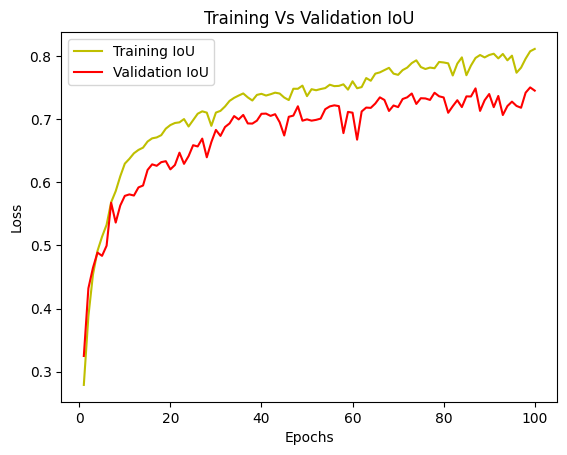

In [53]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [54]:
model_history.params

{'verbose': 1, 'epochs': 100, 'steps': 51}

In [55]:
y_pred = model.predict(X_test)

5/5 [==============================] - 6s 1s/step


In [56]:
len(y_pred)

142

In [57]:
y_pred

array([[[[9.28509422e-03, 5.95733523e-01, 1.15771778e-01,
          2.01499373e-01, 7.44716227e-02, 3.23865656e-03],
         [3.50171980e-03, 6.45108044e-01, 8.00990015e-02,
          2.27998689e-01, 4.28131782e-02, 4.79396927e-04],
         [3.61147663e-03, 6.99030280e-01, 7.80159310e-02,
          1.71054721e-01, 4.78583761e-02, 4.29183623e-04],
         ...,
         [1.87829975e-03, 4.21490997e-01, 3.82099673e-02,
          5.07465601e-01, 3.05996407e-02, 3.55512719e-04],
         [2.12958409e-03, 4.61272687e-01, 4.63759638e-02,
          4.50131744e-01, 3.96907479e-02, 3.99395474e-04],
         [9.45015997e-03, 4.08433676e-01, 1.00146607e-01,
          4.06431824e-01, 7.36956745e-02, 1.84203300e-03]],

        [[3.19501851e-03, 6.47663236e-01, 8.21819827e-02,
          2.31845066e-01, 3.45384479e-02, 5.76219638e-04],
         [5.33126586e-04, 6.86899424e-01, 3.85559537e-02,
          2.54683822e-01, 1.92883760e-02, 3.93380215e-05],
         [6.17176353e-04, 7.59091794e-01, 4.4600

In [58]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [59]:
len(y_pred_argmax)

142

In [60]:
y_pred_argmax

array([[[1, 1, 1, ..., 3, 1, 1],
        [1, 1, 1, ..., 3, 3, 3],
        [1, 1, 1, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 3, 3, 3],
        [2, 2, 2, ..., 3, 3, 3],
        [2, 2, 2, ..., 3, 3, 3],
        ...,
        [2, 2, 2, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [61]:
y_test_argmax = np.argmax(y_test, axis=3)

In [62]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

# Comparing prediction results


using test images using mask images and predicted result images..


In [68]:
import random

In [74]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 94ms/step


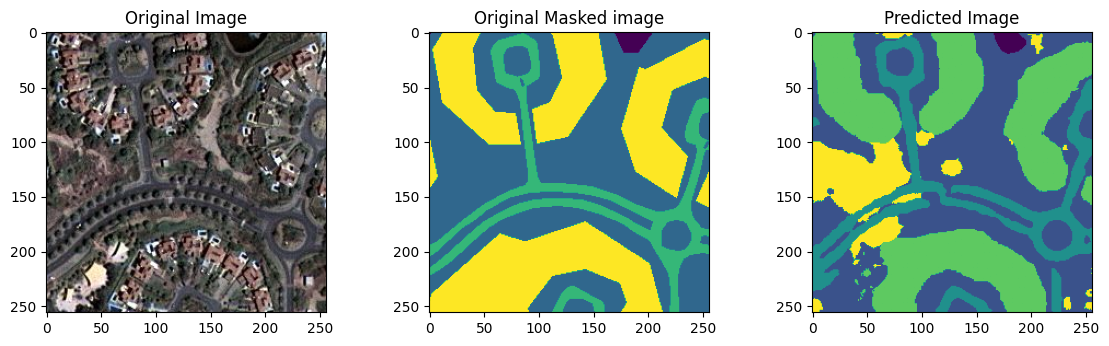

In [75]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)


In [76]:
model.save("satellite_segmentation_full.h5")

In [67]:
!ls -lah 

'ls' is not recognized as an internal or external command,
operable program or batch file.
